## Kaggle 比赛：树叶分类

数据下载地址：https://www.kaggle.com/c/classify-leaves/data

## （1）读取数据

在开始之前，我们先看看数据集长什么样子：
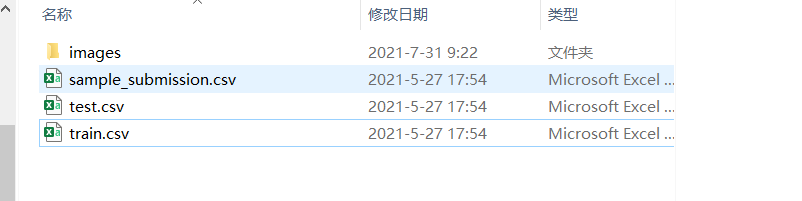
其中.csv中存放的是图片的地址和对应的标签

首先我们读取一下.csv中的数据，看看长什么样子：

In [5]:
# 下面两行是防止内核挂掉加的
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [3]:
train_data = pd.read_csv(r"../data/classify-leaves/train.csv") # 训练数据
test_data = pd.read_csv(r"../data/classify-leaves/test.csv") # 测试数据
print(train_data.shape)
print(test_data.shape)
train_data # 训练数据有标签

(18353, 2)
(8800, 1)


,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera
...,...,...
18348,images/18348.jpg,aesculus_glabra
18349,images/18349.jpg,liquidambar_styraciflua
18350,images/18350.jpg,cedrus_libani
18351,images/18351.jpg,prunus_pensylvanica


In [4]:
test_data # 测试数据没有标签

,image
0,images/18353.jpg
1,images/18354.jpg
2,images/18355.jpg
3,images/18356.jpg
4,images/18357.jpg
...,...
8795,images/27148.jpg
8796,images/27149.jpg
8797,images/27150.jpg
8798,images/27151.jpg


对数据有了一个直观的理解，接下来我们开始读取数据：读取数据集所在地址

In [6]:
data_dir = os.path.join('..', 'data', 'classify-leaves')

整理数据集：将每个类存放一个文件夹

In [39]:
def read_csv_labels(fname):
    """读取 `fname` 来给标签字典返回一个文件名。"""
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'train.csv')) # 存放训练集标签的文件
labels # 是一个字典

{'images/0.jpg': 'maclura_pomifera',
 'images/1.jpg': 'maclura_pomifera',
 'images/2.jpg': 'maclura_pomifera',
 'images/3.jpg': 'maclura_pomifera',
 'images/4.jpg': 'maclura_pomifera',
 'images/5.jpg': 'maclura_pomifera',
 'images/6.jpg': 'ulmus_rubra',
 'images/7.jpg': 'broussonettia_papyrifera',
 'images/8.jpg': 'maclura_pomifera',
 'images/9.jpg': 'broussonettia_papyrifera',
 'images/10.jpg': 'maclura_pomifera',
 'images/11.jpg': 'prunus_virginiana',
 'images/12.jpg': 'maclura_pomifera',
 'images/13.jpg': 'prunus_virginiana',
 'images/14.jpg': 'broussonettia_papyrifera',
 'images/15.jpg': 'maclura_pomifera',
 'images/16.jpg': 'maclura_pomifera',
 'images/17.jpg': 'broussonettia_papyrifera',
 'images/18.jpg': 'maclura_pomifera',
 'images/19.jpg': 'ulmus_rubra',
 'images/20.jpg': 'maclura_pomifera',
 'images/21.jpg': 'maclura_pomifera',
 'images/22.jpg': 'prunus_virginiana',
 'images/23.jpg': 'broussonettia_papyrifera',
 'images/24.jpg': 'maclura_pomifera',
 'images/25.jpg': 'brousson

In [40]:
def copyfile(filename, target_dir):
    """将文件复制到目标目录。"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    # 下面的collections.Counter就是统计label这个字典中有几个类别（返回字典）；.most_common()则转换成元组；[-1][1]则返回最后一个元组的第二个值(因为这个类别数量最小)
    n = collections.Counter(labels.values()).most_common()[-1][1] # n就是数量最少类别对应的数量
    n_valid_per_label = max(1, math.floor(n * valid_ratio)) # 根据最小类别数量，得出验证集的数量
    label_count = {}
    for train_file in labels: # 返回训练集中的图片名字列表(我们看到，训练标签转换成的字典，key就是训练集的图片名字)
        label = labels[train_file] # 每张图片 对应的标签
        fname = os.path.join(data_dir, train_file) # 每个图片的完整路径
        copyfile(
            fname,
            os.path.join(data_dir, 'train_valid_test', 'train_valid', label)) # 将图片复制到指定的目录下，这个是为了交叉验证使用，这里和训练集没区别
        if label not in label_count or label_count[label] < n_valid_per_label: # 制作验证集。注：标签名作为key,value为每个标签的图片数量
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1 # 统计每个标签的图片数量
        else: # 制作训练集
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label # 返回验证集的数量

在预测期间整理测试集，以方便读取

In [44]:
def reorg_test(data_dir):
    test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
    for test_file in test['image']: # 获取测试集图片的名字，复制到指定文件夹下
        copyfile(
            os.path.join(data_dir, test_file),
            os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

调用前面定义的函数，进行整理数据集

In [45]:
def reorg_leave_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'train.csv')) # 是个字典
    reorg_train_valid(data_dir, labels, valid_ratio) # 生成训练集和验证集
    reorg_test(data_dir) # 生成测试集

batch_size = 128
valid_ratio = 0.1
if not os.path.exists(data_dir + "\\" + "train_valid_test"): # 判断是否已经制作好了数据集
    print("start!")
    reorg_leave_data(data_dir, valid_ratio)
else:
    print("Already exists!")
print('finish!')

start!
finish!


接下来对图像进行变换，也就是图像增广： 这里需要说下，图像增广，这里并没有把每张图片变成多张，保存下来。而是每次读入的时候，随机的变换成一张，然后送入模型。从整个模型运行的角度看，实际上就是将数据集变大了，因为每次送入的图片大概率是不一样的（随机变换的）

In [46]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0), # 从图片的中心点剪裁出24*24的图片
                                             ratio=(3.0 / 4.0, 4.0 / 3.0)),
    torchvision.transforms.RandomHorizontalFlip(), # 左右翻转
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                       saturation=0.4),
    # 加入随机噪音
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], # 对图片的每个通道做均值和方差
                                     [0.229, 0.224, 0.225])])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    # 加入随机噪音
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], # 依然 对图片的每个通道做均值和方差
                                     [0.229, 0.224, 0.225])])

读取数据集

In [47]:
# ImageFolder按照文件夹顺序，进行打标签

# 训练集和交叉验证集
train_ds, train_valid_ds = [ 
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']]

# 验证集和测试集
valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test) for folder in ['valid', 'test']]

# 把前面的数据放入torch的DataLoader，则每次迭代时，读取一个batch
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

微调（迁移学习）预训练模型

In [49]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True) # 使用了resnet34的预训练模型
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256), nn.ReLU(), # 在后面输出层中，又增加了几层
                                            nn.Linear(256, 176))
    finetune_net = finetune_net.to(devices[0]) # 将模型送入gpu
    for param in finetune_net.features.parameters(): # 固定住预训练模型中的参数，只调节我们新加的几个层的参数
        param.requires_grad = False
    return finetune_net

计算损失

In [50]:
loss = nn.CrossEntropyLoss(reduction='none') # reduction='none'表示返回n个样本的loss

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return l_sum / n

训练函数

In [52]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0]) # 使用多gpu
    trainer = torch.optim.SGD( # 随机梯度下降
        (param for param in net.parameters() if param.requires_grad), lr=lr,
        momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay) # 使用学习率衰减
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend) # 画图
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0]) # 特征和标签都放到gpu
            trainer.zero_grad() # 梯度清零
            output = net(features) # 得出预测结果
            l = loss(output, labels).sum()
            l.backward() # 反向传播，求梯度
            trainer.step() # 更新参数
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None: # 计算验证集的loss
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.cpu().detach()))
        scheduler.step() # 一个epoch完了，衰减学习率
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

训练和验证模型

train loss 1.759, valid loss 1.753
709.4 examples/sec on [device(type='cuda', index=0)]


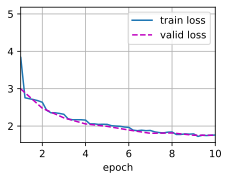

In [53]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

对测试集进行分类并提交结果

train loss 1.579
702.3 examples/sec on [device(type='cuda', index=0)]


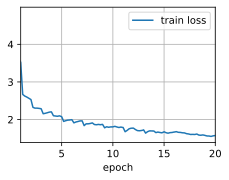

In [58]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay= 4, 0.9

net, preds = get_net(devices), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

test = pd.read_csv(os.path.join(data_dir, 'test.csv')) # 存放 测试集图片地址 的文件
for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = test['image'] # 对应的id
df = pd.DataFrame({'image': sorted_ids, 'label': preds}) # 转换成pandas的DF格式

# .apply()函数：遍历DataFrame的元素（一行数据或者一列数据），默认列遍历
# ImageFolder返回对象的.classes属性：用一个 list 保存类别名称
# 这个的作用是：模型预测出来是概率最大的那个数的下标，在保存文件时，需要把数字类别转换为字符串类别，
# train_valid_ds.classes就是获取字符串类别名（返回的是一个列表），然后使用apply一行一行读取出来，把数字类别转换为字符串类别
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x]) 
df.to_csv(r'..\data\classify-leaves\submission.csv', index=False)